In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install pandas
#!pip install tqdm
#!pip install scipy
#!pip install matchms
#!pip install scikit-learn
#!pip install spec2vec

In [3]:
import os
os.chdir('/Users/sebas/projects/metabolomics')

In [56]:
import gensim
from src.load_data import LoadData
from src.config import Config
from matchms import calculate_scores
from matchms.importing import load_from_mgf,load_from_msp
from spec2vec import Spec2Vec
import matchms.filtering as msfilters
from spec2vec import SpectrumDocument
from spec2vec.model_building import train_new_word2vec_model
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np

In [12]:
ls /Users/sebas/projects/data

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy


## Parameters

In [13]:
data_folder= '/Users/sebas/projects/data/'
dataset_path = data_folder + 'uniformed_test_molecule_pairs.pkl'
gnps_path =  data_folder + 'ALL_GNPS_NO_PROPOGATED_wb.mgf'
janssen_path = data_folder + 'drug_plus.mgf'
nist_path = data_folder + 'hr_msms_nist_all.MSP'
output_pairs_file= data_folder + 'molecular_pairs.pkl'
output_nist_file= data_folder + 'all_spectrums_nist.pkl'
output_gnps_file= data_folder + 'all_spectrums_gnps.pkl'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
model_file = data_folder + 'spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model'
uniformed_molecule_pairs_test_path= data_folder +'uniformed_molecule_pairs_test.pkl'
load_molecule_pairs_file= False

In [14]:
## Load spectrum using spectrumutils

In [15]:
config=Config()

## Load all the data

In [24]:
max_number_spectra_gnps=1000000
max_number_spectra_janssen= 10000000
max_number_spectra_nist=2000
block_size_nist=30000

In [17]:
loader_saver = LoaderSaver(block_size=block_size_nist, 
                               pickle_nist_path =output_nist_file,
                               pickle_gnps_path =output_gnps_file,
                               pickle_janssen_path=output_janssen_file
                               )

In [18]:
all_spectrums_janssen = loader_saver.get_all_spectrums(janssen_path,max_number_spectra_janssen, use_tqdm=True, use_nist=False, config=config, use_janssen=True)

  0%|                                                                                                                                                                                                                         | 2033/10000000 [00:01<2:07:36, 1305.89it/s]


We reached the end of the array at index 2033


In [19]:
all_spectrums_gnps = loader_saver.get_all_spectrums(gnps_path,max_number_spectra_gnps, use_tqdm=True, use_nist=False, config=config)

  0%|▏                                                                                                                                                                                                                            | 700/1000000 [00:00<10:30, 1586.02it/s][12:44:46] SMILES Parse Error: syntax error while parsing: InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)
[12:44:46] SMILES Parse Error: Failed parsing SMILES 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)' for input: 'InChI=1S/C16H21NO2/c1-2-3-4-5-6-11-14-16(19)15(18)12-9-7-8-10-13(12)17-14/h7-10,19H,2-6,11H2,1H3,(H,17,18)'
  0%|▏                                                                                                                                                                                                                            | 869/1000000 [00:00<15:57, 1043.66it/s][12:44:46] Can't kek

We reached the end of the array at index 64364


In [25]:
all_spectrums_nist = loader_saver.get_all_spectrums(nist_path,max_number_spectra_nist, use_tqdm=True, use_nist=True, config=config)

The NIST file contains 61839355 lines
Starting loading spectrums with block size 30000 in the following spectrum index 0 and line number 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [22:08<00:00, 22.58it/s]


Percentage of N/A smiles in current block: 2.6966666666666668%
lenght of spectrums retrievied:14659
Saving spectrums with block size 30000 in the following spectrum index 14659 and updated line number 1249750


In [26]:
len(all_spectrums_gnps), len(all_spectrums_nist), len(all_spectrums_janssen)

(64364, 14659, 2033)

In [27]:
all_spectrums = all_spectrums_gnps + all_spectrums_nist + all_spectrums_janssen

## Load data through matchms

In [28]:
all_spectrums_gnps_MATCHMS = [(s) for s in load_from_mgf(gnps_path)]

In [29]:
all_spectrums_janssen_MATCHMS = [(s) for s in load_from_mgf(janssen_path)]

2024-01-31 13:10:43,844:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,845:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,846:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,847:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,847:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,848:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,849:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,850:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,850:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,850:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,851:WARNING:matchms:add_retention:N/A can't be converted to float.
2024-01-31 13:10:43,852:WARNING:matchms:add

In [34]:
all_spectrums_nist_MATCHMS = list(itertools.islice(load_from_msp(nist_path), 30000))
#all_spectrums_nist_MATCHMS = [s for s in load_from_msp(nist_path)]

In [36]:
len(all_spectrums_gnps_MATCHMS),len(all_spectrums_janssen_MATCHMS),len(all_spectrums_nist_MATCHMS)

(504840, 2546, 30000)

In [37]:
all_spectrums_MATCHMS = all_spectrums_gnps_MATCHMS + all_spectrums_janssen_MATCHMS + all_spectrums_nist_MATCHMS

## Compute a set of molecular pairs

In [38]:
number_pairs=10000

In [39]:
import dill
from src.load_data import LoadData
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver


In [40]:

if load_molecule_pairs_file:
        with open(uniformed_molecule_pairs_test_path, 'rb') as file:
            dataset = dill.load(file)
        molecule_pairs= dataset['uniformed_molecule_pairs_test']
else:
        molecule_pairs= TrainUtils.compute_all_tanimoto_results(all_spectrums, 
                                                                max_combinations=number_pairs, 
                                                                use_tqdm=True, 
                                                                max_mass_diff=config.MAX_MASS_DIFF, 
                                                                min_mass_diff=config.MIN_MASS_DIFF)

Starting computation of molecule pairs
2024-01-31 13:12:25.254239
Computing all the tanimoto results


Processing:   0%|                                                                                                                                                                                                                               | 0/10000 [00:00<?, ?it/s]

Compute all the fingerprints


Processing:   8%|██████████████████                                                                                                                                                                                                   | 847/10000 [00:48<06:10, 24.70it/s]

Number of workers: 15


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:05<00:00, 153.45it/s]

Number of effective pairs retrieved: 10000 
2024-01-31 13:13:30.520757


In [41]:
len(molecule_pairs)

10000

## Use the molecular pairs to match the spectra in matchms

In [42]:
hash_gnps_MATCHMS = [s.spectrum_hash() for s in all_spectrums_gnps_MATCHMS]

In [43]:
hash_janssen_MATCHMS = [s.spectrum_hash() for s in all_spectrums_janssen_MATCHMS]

In [44]:
hash_nist_MATCHMS = [s.spectrum_hash() for s in all_spectrums_nist_MATCHMS]

In [45]:
## check that each one of the datasets is in the respective ms foldersm

In [46]:
is_hash_gnps_su_in_matchms = not(False in [(s.spectrum_hash in hash_gnps_MATCHMS) for s in all_spectrums_gnps])
is_hash_gnps_su_in_matchms

True

In [47]:
is_hash_janssen_su_in_matchms = not(False in [(s.spectrum_hash in hash_janssen_MATCHMS) for s in all_spectrums_janssen])
is_hash_janssen_su_in_matchms

True

In [48]:
is_hash_nist_su_in_matchms = not(False in [(s.spectrum_hash in hash_nist_MATCHMS) for s in all_spectrums_nist])
is_hash_nist_su_in_matchms

True

In [49]:
## sanity check to see that there are no cross appearences

## Load spec2vec model

In [50]:
# Import pre-trained word2vec model (see code example above)
#model_file = "references.model"
model = gensim.models.Word2Vec.load(model_file)

In [61]:
# Define similarity_function
spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=100.0)

## compute spec2vec

In [87]:
def spectrum_processing(s):
    """This is how one would typically design a desired pre- and post-
    processing pipeline."""
    s = msfilters.default_filters(s)
    s = msfilters.add_parent_mass(s)
    s = msfilters.normalize_intensities(s)
    s = msfilters.reduce_to_number_of_peaks(s, n_required=10, ratio_desired=None, n_max=500)
    #s = msfilters.reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5, n_max=500)
    s = msfilters.select_by_mz(s, mz_from=0, mz_to=1000)
    s = msfilters.add_losses(s, loss_mz_from=10.0, loss_mz_to=200.0)
    s = msfilters.require_minimum_number_of_peaks(s, n_required=10)
    return s

In [88]:
target_hashes = [s.spectrum_hash() for s in all_spectrums_MATCHMS]

In [89]:
unique_hashes_in_molecule_pairs= np.unique([m.spectrum_object_0.spectrum_hash for m in molecule_pairs]+[m.spectrum_object_1.spectrum_hash for m in molecule_pairs])

In [90]:
spectrums_match_hash= [(s,t) for s,t in zip(all_spectrums_MATCHMS, target_hashes) if (t in unique_hashes_in_molecule_pairs)]

In [91]:
preprocessed_spectrums = [p[0] for p in spectrums_match_hash]
target_hashes_subset = [p[1] for p in spectrums_match_hash]

In [95]:
for i in tqdm(range(len(preprocessed_spectrums))):
    preprocessed_spectrums[i] = spectrum_processing(preprocessed_spectrums[i])

  2%|████▉                                                                                                                                                                                                                           | 362/16303 [00:00<00:25, 616.46it/s]

2024-01-31 14:01:26,941:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-01-31 14:01:26,943:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-01-31 14:01:26,945:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-01-31 14:01:26,947:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Fe-2H]
2024-01-31 14:01:26,949:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Cr-2H]
2024-01-31 14:01:26,951:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M+Al-2H]


  3%|██████▋                                                                                                                                                                                                                         | 485/16303 [00:00<00:26, 602.50it/s]

2024-01-31 14:01:27,213:WARNING:matchms:interpret_unknown_adduct:Charge was found 0 times in adduct [M-H2+Fe]


  7%|████████████████▎                                                                                                                                                                                                              | 1190/16303 [00:01<00:23, 633.78it/s]

2024-01-31 14:01:28,279:WARNING:matchms:add_losses:No precursor_mz found. Consider applying 'add_precursor_mz' filter first.
2024-01-31 14:01:28,281:WARNING:matchms:add_losses:No precursor_mz found. Consider applying 'add_precursor_mz' filter first.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 11323/16303 [00:18<00:07, 636.20it/s]

2024-01-31 14:01:44,598:WARNING:matchms:derive_adduct_from_name:Two potential adducts were found in the compound name that are both valid adducts. The first adduct is used. The adducts found are: ['[M+2H]2+', '[M+H]+']


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 13332/16303 [00:21<00:04, 639.55it/s]

2024-01-31 14:01:47,706:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,706:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,707:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,708:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,708:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,710:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 13405/16303 [00:21<00:04, 663.50it/s]

2024-01-31 14:01:47,788:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,789:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,790:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,790:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,793:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 13476/16303 [00:21<00:04, 675.12it/s]

2024-01-31 14:01:47,890:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,891:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,897:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,897:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,900:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 13544/16303 [00:21<00:04, 662.77it/s]

2024-01-31 14:01:47,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,998:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,998:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:47,999:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:47,999:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,001:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 13615/16303 [00:21<00:03, 675.25it/s]

2024-01-31 14:01:48,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,099:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,099:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,100:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,100:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 13689/16303 [00:21<00:03, 693.58it/s]

2024-01-31 14:01:48,197:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,198:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,199:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,199:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,200:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,202:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 13759/16303 [00:22<00:04, 620.81it/s]

2024-01-31 14:01:48,338:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,338:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,340:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,340:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,342:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 13823/16303 [00:22<00:04, 569.90it/s]

2024-01-31 14:01:48,474:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,475:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,477:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,478:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,479:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 13888/16303 [00:22<00:04, 588.62it/s]

2024-01-31 14:01:48,576:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,576:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,578:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,578:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,581:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,581:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,582:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 13957/16303 [00:22<00:03, 614.73it/s]

2024-01-31 14:01:48,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,677:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,678:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,678:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,679:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,679:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,681:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 14031/16303 [00:22<00:03, 649.31it/s]

2024-01-31 14:01:48,777:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,777:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,778:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,778:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,780:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,780:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,781:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 14099/16303 [00:22<00:03, 656.83it/s]

2024-01-31 14:01:48,877:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,877:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,879:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,879:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,880:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,881:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,882:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 14173/16303 [00:22<00:03, 680.64it/s]

2024-01-31 14:01:48,977:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,978:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,979:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,979:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,980:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:48,981:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:48,982:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 14242/16303 [00:22<00:03, 614.69it/s]

2024-01-31 14:01:49,116:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,116:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,117:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,117:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,119:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,119:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,120:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 14306/16303 [00:22<00:03, 585.73it/s]

2024-01-31 14:01:49,239:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,239:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,241:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,242:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,245:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,245:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,247:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 14367/16303 [00:23<00:03, 590.59it/s]

2024-01-31 14:01:49,339:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,339:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,341:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,341:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,342:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,342:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,344:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 14441/16303 [00:23<00:02, 630.48it/s]

2024-01-31 14:01:49,440:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,440:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,441:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,441:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,442:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,443:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,444:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 14515/16303 [00:23<00:02, 659.79it/s]

2024-01-31 14:01:49,541:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,541:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,542:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,543:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,544:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,545:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 14582/16303 [00:23<00:02, 574.75it/s]

2024-01-31 14:01:49,696:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,696:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,700:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,700:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,703:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,704:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,707:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 14642/16303 [00:23<00:03, 442.21it/s]

2024-01-31 14:01:49,916:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,916:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,919:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,919:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,923:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:49,923:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:49,927:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 14693/16303 [00:23<00:04, 398.38it/s]

2024-01-31 14:01:50,082:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,082:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,085:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,085:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,089:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,089:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,092:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 14738/16303 [00:23<00:04, 335.76it/s]

2024-01-31 14:01:50,285:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,286:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,291:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,292:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,297:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,298:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,303:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 14776/16303 [00:24<00:05, 288.11it/s]

2024-01-31 14:01:50,481:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,484:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,484:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,487:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,488:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,490:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 14809/16303 [00:24<00:05, 280.07it/s]

2024-01-31 14:01:50,610:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,610:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,613:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,613:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,617:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,617:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,623:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 14840/16303 [00:24<00:05, 271.77it/s]

2024-01-31 14:01:50,736:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,737:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,740:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,741:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,745:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,749:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 14869/16303 [00:24<00:05, 270.46it/s]

2024-01-31 14:01:50,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,846:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,854:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,854:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,858:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 14897/16303 [00:24<00:05, 265.81it/s]

2024-01-31 14:01:50,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,960:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,960:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,964:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:50,964:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:50,968:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 14925/16303 [00:24<00:05, 258.47it/s]

2024-01-31 14:01:51,073:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,073:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,077:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,077:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,080:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,081:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,084:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 14952/16303 [00:24<00:05, 247.68it/s]

2024-01-31 14:01:51,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,198:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,198:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,203:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,203:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,207:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 14977/16303 [00:24<00:05, 242.50it/s]

2024-01-31 14:01:51,304:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,304:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,306:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,307:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,310:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,310:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,313:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 15002/16303 [00:25<00:05, 236.69it/s]

2024-01-31 14:01:51,417:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,418:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,422:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,422:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,426:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,432:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 15026/16303 [00:25<00:05, 227.15it/s]

2024-01-31 14:01:51,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,539:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,539:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,543:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,544:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,546:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 15050/16303 [00:25<00:05, 229.15it/s]

2024-01-31 14:01:51,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,640:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,642:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,642:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,646:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 15075/16303 [00:25<00:05, 233.08it/s]

2024-01-31 14:01:51,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,742:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,746:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,750:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 15102/16303 [00:25<00:04, 242.05it/s]

2024-01-31 14:01:51,842:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,842:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,846:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,847:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,850:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,850:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,855:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 15127/16303 [00:25<00:04, 237.60it/s]

2024-01-31 14:01:51,951:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,952:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,955:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,959:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:51,959:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:51,963:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 15155/16303 [00:25<00:04, 247.49it/s]

2024-01-31 14:01:52,054:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,054:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,057:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,058:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,061:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,061:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,065:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 15182/16303 [00:25<00:04, 252.38it/s]

2024-01-31 14:01:52,157:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,157:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,161:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,161:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,164:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,164:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,167:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 15209/16303 [00:25<00:04, 255.90it/s]

2024-01-31 14:01:52,259:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,259:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,263:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,263:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,266:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,266:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,270:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 15235/16303 [00:26<00:04, 256.47it/s]

2024-01-31 14:01:52,359:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,359:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,363:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,363:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,367:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,367:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,370:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 15261/16303 [00:26<00:04, 250.03it/s]

2024-01-31 14:01:52,471:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,472:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,477:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,477:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,480:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,481:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,486:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 15287/16303 [00:26<00:04, 241.74it/s]

2024-01-31 14:01:52,587:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,588:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,591:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,592:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,595:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,595:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,599:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 15314/16303 [00:26<00:03, 248.81it/s]

2024-01-31 14:01:52,687:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,687:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,691:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,691:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,695:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,695:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,699:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 15339/16303 [00:26<00:03, 245.27it/s]

2024-01-31 14:01:52,792:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,796:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,796:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,800:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,801:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,804:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 15366/16303 [00:26<00:03, 251.24it/s]

2024-01-31 14:01:52,894:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,894:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,898:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,898:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,902:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,902:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:52,906:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 15393/16303 [00:26<00:03, 254.09it/s]

2024-01-31 14:01:52,997:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:52,997:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,000:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,001:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,004:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,004:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,007:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 15420/16303 [00:26<00:03, 255.91it/s]

2024-01-31 14:01:53,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,105:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,109:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,110:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,113:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 15447/16303 [00:26<00:03, 257.46it/s]

2024-01-31 14:01:53,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,205:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,209:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,212:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,213:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,216:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 15474/16303 [00:26<00:03, 258.95it/s]

2024-01-31 14:01:53,308:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,308:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,311:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,313:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,313:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,316:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 15502/16303 [00:27<00:03, 264.85it/s]

2024-01-31 14:01:53,408:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,408:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,412:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,412:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,416:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,416:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,420:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 15530/16303 [00:27<00:02, 268.20it/s]

2024-01-31 14:01:53,509:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,509:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,513:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,513:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,516:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,516:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,520:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 15557/16303 [00:27<00:02, 254.92it/s]

2024-01-31 14:01:53,628:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,628:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,632:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,632:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,636:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,636:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,640:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 15583/16303 [00:27<00:02, 253.64it/s]

2024-01-31 14:01:53,731:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,731:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,734:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,744:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 15610/16303 [00:27<00:02, 257.35it/s]

2024-01-31 14:01:53,833:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,833:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,837:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,838:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,842:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,842:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,845:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 15636/16303 [00:27<00:02, 247.23it/s]

2024-01-31 14:01:53,949:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,949:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,956:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,956:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,961:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:53,962:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:53,965:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 15661/16303 [00:27<00:02, 221.69it/s]

2024-01-31 14:01:54,090:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,091:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,094:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,098:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,102:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 15685/16303 [00:27<00:02, 224.31it/s]

2024-01-31 14:01:54,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,195:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,200:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,205:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,210:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 15708/16303 [00:27<00:02, 225.23it/s]

2024-01-31 14:01:54,294:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,295:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,299:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,299:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,302:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,303:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,305:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 15735/16303 [00:28<00:02, 235.58it/s]

2024-01-31 14:01:54,398:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,398:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,401:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,402:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,405:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,406:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,408:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 15763/16303 [00:28<00:02, 247.50it/s]

2024-01-31 14:01:54,498:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,499:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,502:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,502:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,506:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,506:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,510:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 15790/16303 [00:28<00:02, 252.60it/s]

2024-01-31 14:01:54,601:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,601:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,606:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,606:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,612:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,612:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,616:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 15816/16303 [00:28<00:01, 248.92it/s]

2024-01-31 14:01:54,709:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,709:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,712:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,713:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,716:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,716:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,719:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 15842/16303 [00:28<00:01, 245.17it/s]

2024-01-31 14:01:54,818:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,819:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,823:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,823:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,827:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,827:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,831:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 15867/16303 [00:28<00:01, 238.95it/s]

2024-01-31 14:01:54,930:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,930:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,934:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,934:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,939:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:54,939:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:54,943:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 15892/16303 [00:28<00:01, 240.63it/s]

2024-01-31 14:01:55,032:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,032:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,037:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,038:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,041:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,042:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,045:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 15917/16303 [00:28<00:01, 234.48it/s]

2024-01-31 14:01:55,146:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,146:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,152:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,152:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,156:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,156:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,159:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 15941/16303 [00:28<00:01, 232.99it/s]

2024-01-31 14:01:55,249:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,249:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,252:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,252:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,257:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,257:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,261:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 15967/16303 [00:29<00:01, 240.35it/s]

2024-01-31 14:01:55,350:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,350:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,354:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,354:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,358:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,358:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,362:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 15994/16303 [00:29<00:01, 247.94it/s]

2024-01-31 14:01:55,451:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,452:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,455:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,456:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,459:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,459:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,463:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 16020/16303 [00:29<00:01, 248.74it/s]

2024-01-31 14:01:55,555:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,555:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,559:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,559:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,562:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,563:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,566:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 16045/16303 [00:29<00:01, 244.99it/s]

2024-01-31 14:01:55,663:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,663:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,667:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,668:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,671:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,672:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,676:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 16070/16303 [00:29<00:01, 232.20it/s]

2024-01-31 14:01:55,782:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,782:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,786:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,786:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,791:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,792:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,797:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 16095/16303 [00:29<00:00, 235.97it/s]

2024-01-31 14:01:55,884:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,884:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,889:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,889:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,893:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,893:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,896:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 16121/16303 [00:29<00:00, 242.30it/s]

2024-01-31 14:01:55,984:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,985:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,987:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,988:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,992:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:55,992:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:55,996:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 16146/16303 [00:29<00:00, 237.97it/s]

2024-01-31 14:01:56,094:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,094:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,097:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,097:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,101:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,101:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,105:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 16170/16303 [00:29<00:00, 237.95it/s]

2024-01-31 14:01:56,195:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,196:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,201:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,201:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,206:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,206:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,209:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 16194/16303 [00:29<00:00, 230.83it/s]

2024-01-31 14:01:56,307:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,307:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,311:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,312:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,315:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,316:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,320:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 16218/16303 [00:30<00:00, 223.11it/s]

2024-01-31 14:01:56,423:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,423:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,426:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,427:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,431:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,431:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,435:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 16245/16303 [00:30<00:00, 234.27it/s]

2024-01-31 14:01:56,527:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,527:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,531:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,531:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,534:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,534:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,538:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 16271/16303 [00:30<00:00, 239.50it/s]

2024-01-31 14:01:56,629:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,629:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,633:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,633:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,637:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,637:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,641:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 16296/16303 [00:30<00:00, 238.95it/s]

2024-01-31 14:01:56,734:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,735:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,739:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,739:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,742:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entries. Consider prior run of `derive_ionmode()` and `correct_charge()` filters.
2024-01-31 14:01:56,743:WARNING:matchms:add_parent_mass:Not sufficient spectrum metadata to derive parent mass.
2024-01-31 14:01:56,746:WARNING:matchms:derive_precursor_mz_and_parent_mass:Missing charge and ionmode entrie

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16303/16303 [00:30<00:00, 535.53it/s]


In [96]:
len(preprocessed_spectrums)

16303

In [97]:
tanimotos= []
scores= []
for m in tqdm(molecule_pairs):
    hash_0 = m.spectrum_object_0.spectrum_hash
    hash_1 = m.spectrum_object_1.spectrum_hash

    # search for right spectra
    #spectrum_found_0_ms = [s for s,t in zip(preprocessed_spectrums,target_hashes) if t==hash_0 ][0]
    #spectrum_found_1_ms = [s for s,t in zip(preprocessed_spectrums,target_hashes) if t==hash_1 ][0]
    spectrum_found_0_ms = next(s for s, t in zip(preprocessed_spectrums, target_hashes_subset) if t == hash_0)
    spectrum_found_1_ms = next(s for s, t in zip(preprocessed_spectrums, target_hashes_subset) if t == hash_1)
    
    # calculate scores
    if (spectrum_found_0_ms is not None) and (spectrum_found_1_ms is not None):
        score = calculate_scores([spectrum_found_0_ms], [spectrum_found_1_ms], spec2vec_similarity) 
        score = score.scores_by_query(spectrum_found_1_ms, sort=True)[0][1]
        tanimotos.append(m.similarity)
        scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 723.60it/s]


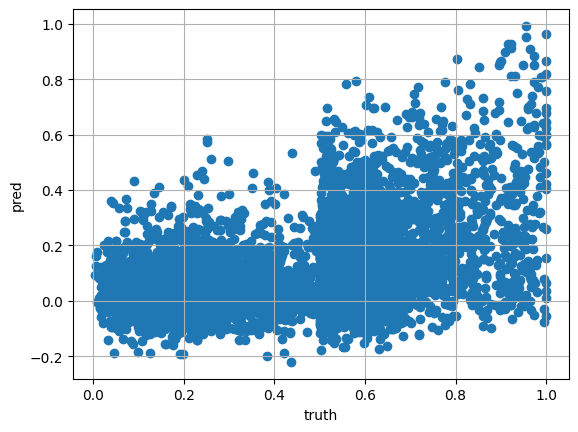

In [98]:
import matplotlib.pyplot as plt
plt.scatter(tanimotos, scores)
plt.ylabel('pred')
plt.xlabel('truth')
plt.grid()

In [99]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_scores, title='ROC Curve', roc_file_path='./roc_curve.png'):
        """
        Compute and plot the Receiver Operating Characteristic (ROC) curve.
    
        """
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(4, 4))
        plt.plot(fpr, tpr, color='r', lw=2, label=f'AUC = {roc_auc:.2f}')
        #plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.grid()
        plt.title(title)
        plt.legend(loc='lower right')
        plt.savefig(roc_file_path)

In [100]:
ground_truth = [1 if t>0.7 else 0 for t in tanimotos]

In [101]:
import numpy as np
np.sum(ground_truth)

792

In [102]:
scores_roc = [s if s>0 else 0 for s in scores ]

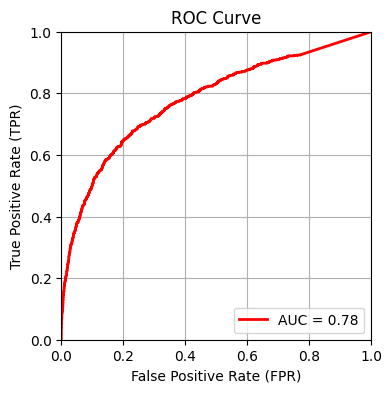

In [103]:
plot_roc_curve(ground_truth, scores_roc)